In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mldataset/ddxplus/validate.csv
/kaggle/input/mldataset/ddxplus/README.md
/kaggle/input/mldataset/ddxplus/release_conditions.json
/kaggle/input/mldataset/ddxplus/release_evidences.json
/kaggle/input/mldataset/ddxplus/train.csv
/kaggle/input/mldataset/ddxplus/test.csv


In [2]:
import pandas as pd

# Load the train, test, and validate datasets
train_df = pd.read_csv('/kaggle/input/mldataset/ddxplus/train.csv')
test_df = pd.read_csv('/kaggle/input/mldataset/ddxplus/test.csv')
validate_df = pd.read_csv('/kaggle/input/mldataset/ddxplus/validate.csv')

# Display the first few rows of the train dataset
train_df.head()

,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE
0,18,"[['Bronchitis', 0.19171203430383882], ['Pneumo...",M,URTI,"['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54...",E_91
1,21,"[['HIV (initial infection)', 0.518950056440760...",M,HIV (initial infection),"['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_...",E_50
2,19,"[['Bronchitis', 0.11278064619119596], ['Pneumo...",F,Pneumonia,"['E_53', 'E_54_@_V_179', 'E_54_@_V_192', 'E_55...",E_77
3,34,"[['URTI', 0.23859396799565236], ['Cluster head...",F,URTI,"['E_48', 'E_53', 'E_54_@_V_183', 'E_55_@_V_89'...",E_53
4,36,"[['URTI', 0.23677812769175735], ['Influenza', ...",M,URTI,"['E_49', 'E_50', 'E_53', 'E_54_@_V_183', 'E_55...",E_201


In [3]:

import json

# Load JSON files
with open('/kaggle/input/mldataset/ddxplus/release_conditions.json', 'r') as f:
    conditions = json.load(f)
with open('/kaggle/input/mldataset/ddxplus/release_evidences.json', 'r') as f:
    evidences = json.load(f)

# Convert JSON to DataFrames for easier inspection (optional)
conditions_df = pd.DataFrame.from_dict(conditions, orient='index')
evidences_df = pd.DataFrame.from_dict(evidences, orient='index')

# Display the first few rows
print("Conditions (Diseases):")
print(conditions_df.head())
print("\nEvidences (Symptoms):")
print(evidences_df.head())

Conditions (Diseases):
                                    condition_name  \
Spontaneous pneumothorax  Spontaneous pneumothorax   
Cluster headache                  Cluster headache   
Boerhaave                                Boerhaave   
Spontaneous rib fracture  Spontaneous rib fracture   
GERD                                          GERD   

                                        cond-name-fr  \
Spontaneous pneumothorax       Pneumothorax spontané   
Cluster headache                  Céphalée en grappe   
Boerhaave                      Syndrome de Boerhaave   
Spontaneous rib fracture  Fracture de côte spontanée   
GERD                                             RGO   

                                     cond-name-eng icd10-id  \
Spontaneous pneumothorax  Spontaneous pneumothorax      J93   
Cluster headache                  Cluster headache  g44.009   
Boerhaave                                Boerhaave    K22.3   
Spontaneous rib fracture  Spontaneous rib fracture    S22.9   


In [4]:
def map_symptom_codes(symptom_dict, evidences_df):
    return [evidences_df.loc[code]["question_en"] for code in symptom_dict.keys() if code in evidences_df.index]

conditions_df["symptom_questions"] = conditions_df["symptoms"].apply(lambda x: map_symptom_codes(x, evidences_df))
conditions_df["antecedent_questions"] = conditions_df["antecedents"].apply(lambda x: map_symptom_codes(x, evidences_df))


In [5]:
print(conditions_df[["condition_name", "symptom_questions", "antecedent_questions"]].head())


                                    condition_name  \
Spontaneous pneumothorax  Spontaneous pneumothorax   
Cluster headache                  Cluster headache   
Boerhaave                                Boerhaave   
Spontaneous rib fracture  Spontaneous rib fracture   
GERD                                          GERD   

                                                          symptom_questions  \
Spontaneous pneumothorax  [Do you feel pain somewhere?, Do you have pain...   
Cluster headache          [Do you feel pain somewhere?, Do you have pain...   
Boerhaave                 [Do you feel pain somewhere?, Do you have pain...   
Spontaneous rib fracture  [Do you feel pain somewhere?, Do you have pain...   
GERD                      [Do you have a burning sensation that starts i...   

                                                       antecedent_questions  
Spontaneous pneumothorax  [Do you smoke cigarettes?, Have any of your fa...  
Cluster headache          [Have any of your 

In [6]:
# Map PATHOLOGY to condition_name
train_df['disease_name'] = train_df['PATHOLOGY'].map(lambda x: conditions.get(x, {}).get('condition_name', x))

# Display the result
print(train_df[['PATHOLOGY', 'disease_name']].head())

                 PATHOLOGY             disease_name
0                     URTI                     URTI
1  HIV (initial infection)  HIV (initial infection)
2                Pneumonia                Pneumonia
3                     URTI                     URTI
4                     URTI                     URTI


In [7]:
# Delete the symptom_questions and antecedent_questions columns
conditions_df = conditions_df.drop(columns=["symptom_questions", "antecedent_questions"], errors="ignore")

# Verify the columns are removed
print(conditions_df.columns)

Index(['condition_name', 'cond-name-fr', 'cond-name-eng', 'icd10-id',
       'symptoms', 'antecedents', 'severity'],
      dtype='object')


In [8]:
def map_symptom_codes(symptom_dict, evidences_df):
    # Return list of English questions for valid symptom codes
    return [evidences_df.loc[code, "question_en"] for code in symptom_dict.keys() if code in evidences_df.index]

# Apply to symptoms and antecedents in conditions_df
conditions_df["symptom_questions"] = conditions_df["symptoms"].apply(lambda x: map_symptom_codes(x, evidences_df))
conditions_df["antecedent_questions"] = conditions_df["antecedents"].apply(lambda x: map_symptom_codes(x, evidences_df))

# Display the result
print(conditions_df[["condition_name", "symptom_questions", "antecedent_questions"]].head())

                                    condition_name  \
Spontaneous pneumothorax  Spontaneous pneumothorax   
Cluster headache                  Cluster headache   
Boerhaave                                Boerhaave   
Spontaneous rib fracture  Spontaneous rib fracture   
GERD                                          GERD   

                                                          symptom_questions  \
Spontaneous pneumothorax  [Do you feel pain somewhere?, Do you have pain...   
Cluster headache          [Do you feel pain somewhere?, Do you have pain...   
Boerhaave                 [Do you feel pain somewhere?, Do you have pain...   
Spontaneous rib fracture  [Do you feel pain somewhere?, Do you have pain...   
GERD                      [Do you have a burning sensation that starts i...   

                                                       antecedent_questions  
Spontaneous pneumothorax  [Do you smoke cigarettes?, Have any of your fa...  
Cluster headache          [Have any of your 

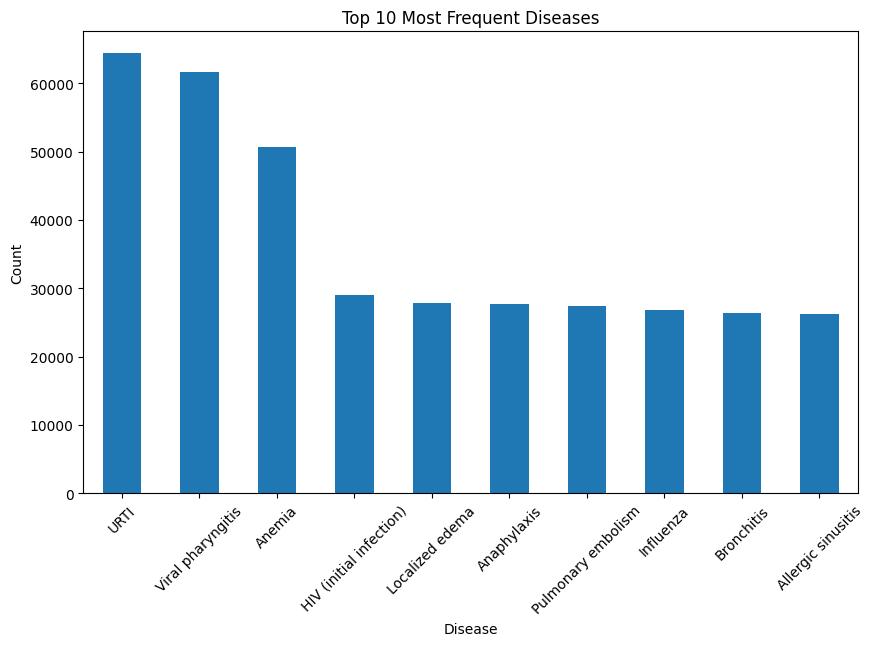

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 10 diseases
plt.figure(figsize=(10, 6))
train_df['disease_name'].value_counts().head(10).plot(kind='bar', color='#1f77b4')
plt.title('Top 10 Most Frequent Diseases')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Column names from conditions_df
print("Conditions DataFrame columns:")
print(conditions_df.columns.tolist())

# Column names from evidences_df
print("\nEvidences DataFrame columns:")
print(evidences_df.columns.tolist())


print("Train columns:", train_df.columns.tolist())
print("Validate columns:", validate_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())

Conditions DataFrame columns:
['condition_name', 'cond-name-fr', 'cond-name-eng', 'icd10-id', 'symptoms', 'antecedents', 'severity', 'symptom_questions', 'antecedent_questions']

Evidences DataFrame columns:
['name', 'code_question', 'question_fr', 'question_en', 'is_antecedent', 'default_value', 'value_meaning', 'possible-values', 'data_type']
Train columns: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE', 'disease_name']
Validate columns: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE']
Test columns: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE']


In [11]:
!pip install transformers -q
from transformers import AutoTokenizer, AutoModel
import torch


In [12]:
model = AutoModel.from_pretrained('Simonlee711/Clinical_ModernBERT')
tokenizer = AutoTokenizer.from_pretrained('Simonlee711/Clinical_ModernBERT')

2025-08-05 10:36:32.330198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754390192.352946     192 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754390192.359844     192 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of BertModel were not initialized from the model checkpoint at Simonlee711/Clinical_ModernBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_dim)
    return cls_embedding.squeeze()


In [14]:
# Example: Get similarity between INITIAL_EVIDENCE and each item in EVIDENCES (row 0)
import torch.nn.functional as F
import ast  # to safely parse stringified lists

row = train_df.iloc[0]

initial_text = row["INITIAL_EVIDENCE"]
evidence_list = ast.literal_eval(row["EVIDENCES"])  # list of evidences (strings)

# Get embedding for initial evidence
init_embed = get_cls_embedding(initial_text)

# Compute cosine similarity with each evidence in EVIDENCES
for evidence in evidence_list:
    ev_embed = get_cls_embedding(evidence)
    similarity = F.cosine_similarity(init_embed, ev_embed, dim=0).item()
    print(f"Similarity with evidence '{evidence}': {similarity:.4f}")


Similarity with evidence 'E_48': 0.9743
Similarity with evidence 'E_50': 0.9773
Similarity with evidence 'E_53': 0.9617
Similarity with evidence 'E_54_@_V_161': 0.9374
Similarity with evidence 'E_54_@_V_183': 0.9372
Similarity with evidence 'E_55_@_V_89': 0.9381
Similarity with evidence 'E_55_@_V_108': 0.9328
Similarity with evidence 'E_55_@_V_167': 0.9304
Similarity with evidence 'E_56_@_4': 0.9519
Similarity with evidence 'E_57_@_V_123': 0.9350
Similarity with evidence 'E_58_@_3': 0.9456
Similarity with evidence 'E_59_@_3': 0.9432
Similarity with evidence 'E_77': 0.9669
Similarity with evidence 'E_79': 0.9777
Similarity with evidence 'E_91': 1.0000
Similarity with evidence 'E_97': 0.9785
Similarity with evidence 'E_201': 0.9638
Similarity with evidence 'E_204_@_V_10': 0.9401
Similarity with evidence 'E_222': 0.9715


In [15]:
# Assuming you stored the results in a list of tuples: [(evidence_id, score), ...]
top_similar = [
    ('E_91', 1.0000),
    ('E_97', 0.9785),
    ('E_79', 0.9777)
]

# Convert to DataFrame for display
import pandas as pd

top_evidence_ids = [eid for eid, _ in top_similar]

# Merge with evidences_df to get full info
matched = evidences_df[evidences_df['code_question'].isin(top_evidence_ids)][
    ['code_question', 'question_en', 'value_meaning', 'data_type']
]
print(matched)


     code_question                                        question_en  \
E_91          E_91  Do you have a fever (either felt or measured w...   
E_97          E_97                         Do you have a sore throat?   
E_79          E_79                           Do you smoke cigarettes?   

     value_meaning data_type  
E_91            {}         B  
E_97            {}         B  
E_79            {}         B  


In [23]:
from transformers import AutoModel

model2 = AutoModel.from_pretrained("thomas-sounack/BioClinical-ModernBERT-base")
print(model2.__class__)

<class 'transformers.models.modernbert.modeling_modernbert.ModernBertModel'>
